# Tutorial 02: Satellite Interference Analysis

This tutorial explores satellite interference modeling in radio astronomy observations. It covers:

1. Setting up satellite constellations and transmitters
2. Loading satellite trajectory data
3. Implementing beam avoidance strategies
4. Analyzing interference patterns
5. Comparing different satellite models
6. Comprehensive four-scenario comparison analysis

## Learning Objectives:
- Understand satellite constellation modeling
- Learn beam avoidance techniques for interference mitigation
- Explore different satellite antenna patterns and their effects
- Analyze interference impact on radio astronomy observations
- Compare multiple interference scenarios (with/without beam avoidance, no satellites, constant gain)

## Prerequisites:
- Completion of Tutorial 01: Basic Radio Astronomy Observation
- Understanding of antenna patterns and link budgets

## Output Files:
- `02_satellite_antenna_pattern.png`: Satellite antenna gain patterns
- `02_satellite_positions.png`: Satellite positions at specific time
- `02_satellite_trajectories.png`: Satellite trajectories over observation period
- `02_satellite_interference_comparison_all_scenarios.png`: Comprehensive four-scenario comparison


## Import Required Libraries

First, import the necessary libraries and set up the Python path to access the RSC-SIM modules.


In [11]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Add the src directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/src')

# Add the modular_tutorials directory to the Python path
sys.path.insert(0, '/Users/lkruczek/Documents/SpectrumX/github/flagship2/RSC-SIM/modular_tutorials')

from radio_types import Trajectory, Observation, Constellation
from obs_mdl import model_observed_temp
from astro_mdl import temperature_to_power

# Import shared utilities
from shared import (
    setup_westford_telescope,
    setup_satellite_transmitter,
    setup_constant_gain_satellite,
    create_sky_model,
    setup_plotting,
    plot_antenna_pattern,
    plot_satellite_positions,
    plot_satellite_trajectories,
    OBSERVATION_START,
    OBSERVATION_END,
    OFFSET_ANGLES,
    TIME_ON_SOURCE,
    MIN_ELEVATION,
    BANDWIDTH,
    STARLINK_TRAJECTORY_FILE
)

# Import satellite modeling functions
from sat_mdl import sat_link_budget_vectorized

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


## Step 1: Set Up the Telescope Instrument

Let's set up the radio telescope instrument using the Westford telescope configuration.


In [12]:
# Set up plotting
setup_plotting()

print("Setting up the Westford telescope instrument...")

telescope = setup_westford_telescope()
print("✓ Telescope instrument created")
print(f"  - Center frequency: {telescope.get_center_freq()/1e9:.3f} GHz")
print(f"  - Bandwidth: {telescope.get_bandwidth()/1e3:.1f} kHz")
print(f"  - Physical temperature: {telescope.get_phy_temp():.1f} K")


Setting up the Westford telescope instrument...
This power_pattern_from_cut_file function assumes Daniel Sheen generated files
✓ Telescope instrument created
  - Center frequency: 11.325 GHz
  - Bandwidth: 1.0 kHz
  - Physical temperature: 300.0 K


## Step 2: Load Source Trajectory

Now we'll load the trajectory data for our astronomical source (Cas A - Cassiopeia A).


In [13]:
print("Loading Cas A source trajectory...")

# Load source trajectory from file
source_trajectory = Trajectory.from_file(
    os.path.join(os.path.dirname(os.path.abspath('__file__')), "data",
                 "casA_trajectory_Westford_2025-02-18T15_00_00.000_2025-02-18T15_45_00.000.arrow"),
    time_tag='time_stamps',
    elevation_tag='altitudes',
    azimuth_tag='azimuths',
    distance_tag='distances'
)
print("✓ Source trajectory loaded")
print(f"  - Time range: {source_trajectory.get_traj()['times'].min()} to "
      f"{source_trajectory.get_traj()['times'].max()}")


Loading Cas A source trajectory...
✓ Source trajectory loaded
  - Time range: 2025-02-18 15:00:00 to 2025-02-18 15:45:00


## Step 3: Create Observation Plan

Create an observation plan that includes both ON-source and OFF-source observations.


In [14]:
print("Creating observation plan...")

# Create pointing trajectory with offset
pointing_trajectory = Trajectory(source_trajectory.traj.copy())

# Apply offset for OFF source observation
mask = (pointing_trajectory.traj['times'] >= OBSERVATION_START) & \
       (pointing_trajectory.traj['times'] <= TIME_ON_SOURCE)
pointing_trajectory.traj.loc[mask, 'azimuths'] += OFFSET_ANGLES[0]
pointing_trajectory.traj.loc[mask, 'elevations'] += OFFSET_ANGLES[1]

# Filter low elevation points
elevation_filter = ('elevations', lambda e: e > MIN_ELEVATION)

# Create observation
observation = Observation.from_dates(
    OBSERVATION_START,
    OBSERVATION_END,
    pointing_trajectory,
    telescope,
    filt_funcs=(elevation_filter,)
)
print("✓ Observation created")
print(f"  - Duration: {OBSERVATION_END - OBSERVATION_START}")
print(f"  - OFF source: {OBSERVATION_START} to {TIME_ON_SOURCE}")
print(f"  - ON source: {TIME_ON_SOURCE} to {OBSERVATION_END}")


Creating observation plan...
✓ Observation created
  - Duration: 0:10:00
  - OFF source: 2025-02-18 15:30:00 to 2025-02-18 15:35:00
  - ON source: 2025-02-18 15:35:00 to 2025-02-18 15:40:00


## Step 4: Set Up Satellite Transmitters

Set up different types of satellite transmitters to model various interference scenarios.


In [15]:
print("Setting up satellite transmitters...")

# Create standard satellite transmitter with ITU gain pattern
satellite_transmitter = setup_satellite_transmitter()
print("✓ Standard satellite transmitter created")
print(f"  - Max gain: {satellite_transmitter.get_antenna().get_boresight_gain():.1f}")
print("  - Half beamwidth: 3.0 degrees")
transmit_power = 10 * np.log10(temperature_to_power(
    satellite_transmitter.get_inst_signal()(OBSERVATION_START,
                                            satellite_transmitter.get_center_freq()), 1.0))
print(f"  - Transmit power: {transmit_power:.1f} dBW")

# Create constant gain satellite for comparison
constant_gain_satellite = setup_constant_gain_satellite()
print("✓ Constant gain satellite transmitter created")
print(f"  - Constant gain: {constant_gain_satellite.get_antenna().get_boresight_gain():.1f}")


Setting up satellite transmitters...
✓ Standard satellite transmitter created
  - Max gain: 8511.4
  - Half beamwidth: 3.0 degrees
  - Transmit power: 9.8 dBW
✓ Constant gain satellite transmitter created
  - Constant gain: 0.1


### Visualize the Satellite Antenna Pattern

Let's plot and visualize the satellite antenna gain pattern.


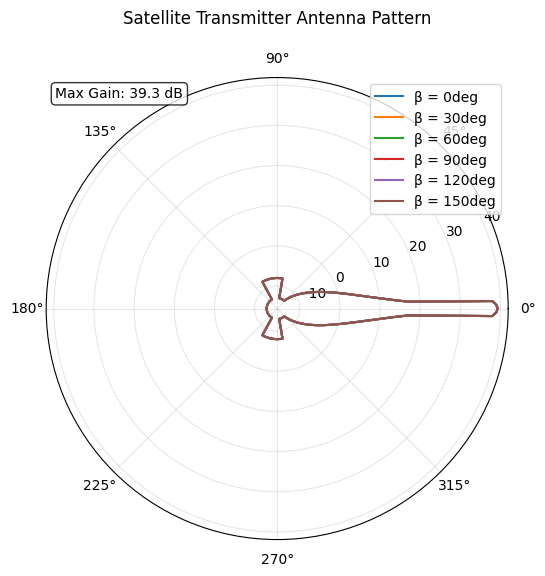

✓ Satellite antenna pattern saved as '02_satellite_antenna_pattern.png'


In [16]:
# Plot satellite antenna patterns
fig, ax = plot_antenna_pattern(satellite_transmitter.get_antenna(), "Satellite Transmitter Antenna Pattern")
plt.savefig('02_satellite_antenna_pattern.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Satellite antenna pattern saved as '02_satellite_antenna_pattern.png'")


## Step 5: Load Satellite Constellation

Now let's load the Starlink satellite constellation data and set up different scenarios for analysis.


In [17]:
print("Loading Starlink satellite constellation...")

# Define link budget wrapper functions
def lnk_bdgt(*args, **kwargs):
    """
    Link budget wrapper function that handles beam avoidance parameters.
    """
    return sat_link_budget_vectorized(*args, **kwargs)


def lnk_bdgt_beam_avoid(*args, **kwargs):
    """
    Link budget wrapper function with beam avoidance enabled.
    """
    return sat_link_budget_vectorized(*args, beam_avoid=10.0, turn_off=False, **kwargs)

# Load satellite constellation from file (without beam avoidance)
constellation = Constellation.from_file(
    STARLINK_TRAJECTORY_FILE,
    observation,
    satellite_transmitter,
    lnk_bdgt,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    # Filter DTC satellites and above 20° elevation
    filt_funcs=(('sat', lambda s: ~s.str.contains('DTC')), ('elevations', lambda e: e > 20.0))
)
print("✓ Satellite constellation loaded (without beam avoidance)")
print(f"  - Number of satellites: {len(constellation.sats['sat'].unique())}")
print(f"  - Time range: {constellation.sats['times'].min()} to {constellation.sats['times'].max()}")

# Create constellation with beam avoidance
constellation_beam_avoid = Constellation.from_file(
    STARLINK_TRAJECTORY_FILE,
    observation,
    satellite_transmitter,
    lnk_bdgt_beam_avoid,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(('sat', lambda s: ~s.str.contains('DTC')), ('elevations', lambda e: e > 20.0))
)
print("✓ Satellite constellation with beam avoidance loaded")


Loading Starlink satellite constellation...
✓ Satellite constellation loaded (without beam avoidance)
  - Number of satellites: 201
  - Time range: 2025-02-18 15:30:00 to 2025-02-18 15:40:00
✓ Satellite constellation with beam avoidance loaded


## Step 6: Visualize Satellite Positions and Trajectories

Let's create visualizations to understand where satellites are located and how they move during our observation.


Visualizing satellite positions at specific time...
  - Study time for satellite positions: 2025-02-18 15:34:29
  - Telescope pointing: 4.8° azimuth, 41.9° elevation


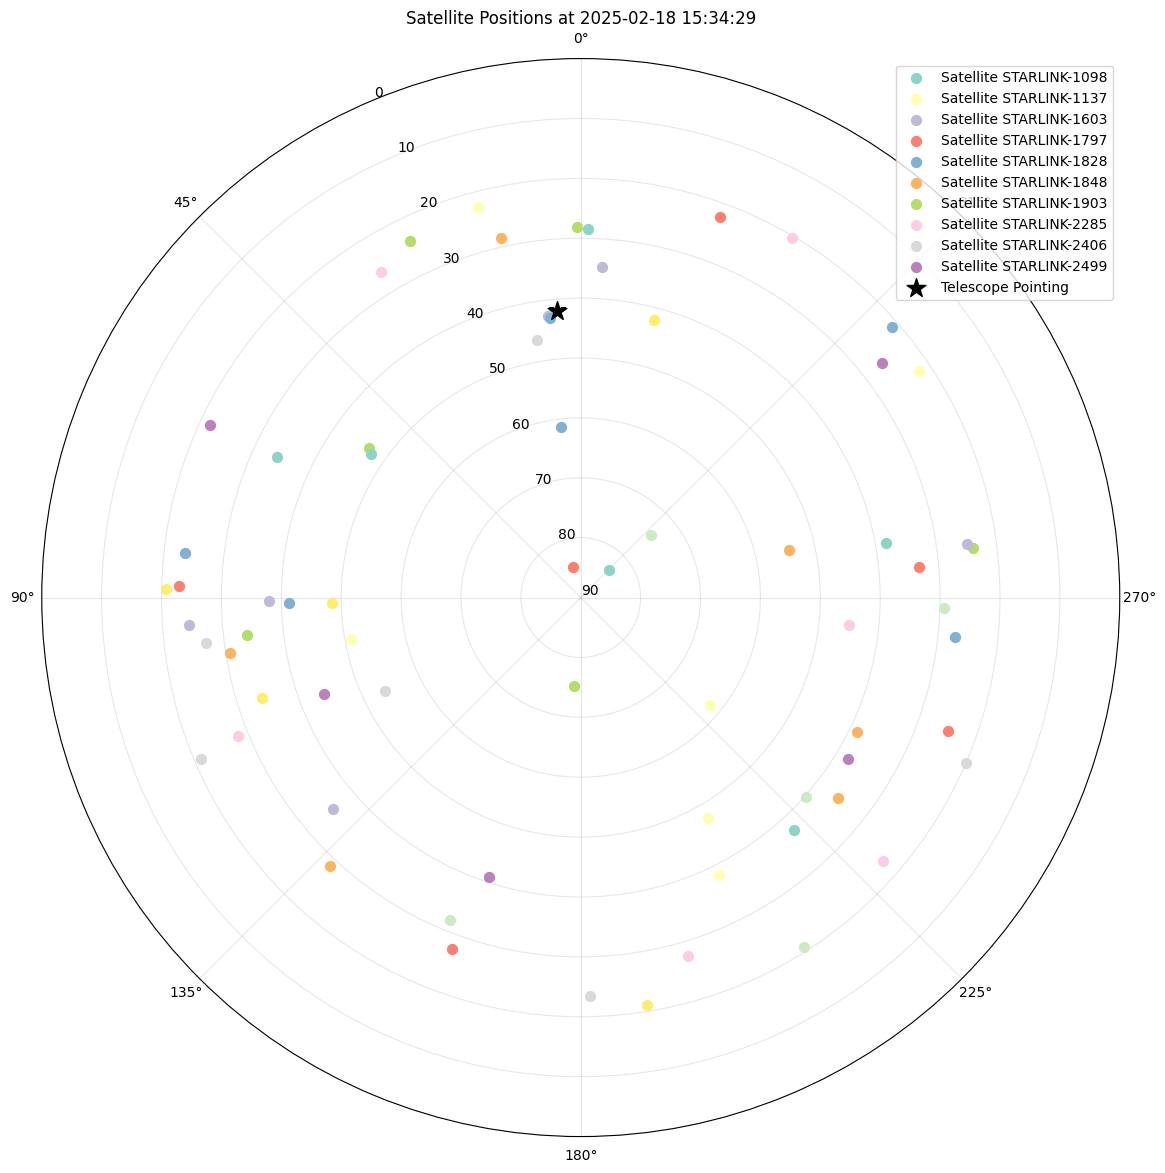

✓ Satellite positions saved as '02_satellite_positions.png'


In [18]:
print("Visualizing satellite positions at specific time...")

# Choose a study time for satellite positions
dateformat = "%Y-%m-%dT%H:%M:%S.%f"
study_time = datetime.strptime("2025-02-18T15:34:29.000", dateformat)
print(f"  - Study time for satellite positions: {study_time}")

# Get telescope pointing coordinates
instru_pt = observation.get_traj()[observation.get_traj()['times'] == study_time]
if len(instru_pt) > 0:
    azimuth = instru_pt.iloc[0]['azimuths']
    elevation = instru_pt.iloc[0]['elevations']
    print(f"  - Telescope pointing: {azimuth:.1f}° azimuth, {elevation:.1f}° elevation")

fig, ax = plot_satellite_positions(constellation, study_time,
                                   observation,
                                   f"Satellite Positions at {study_time}")
plt.savefig('02_satellite_positions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Satellite positions saved as '02_satellite_positions.png'")


Plotting satellite trajectories...


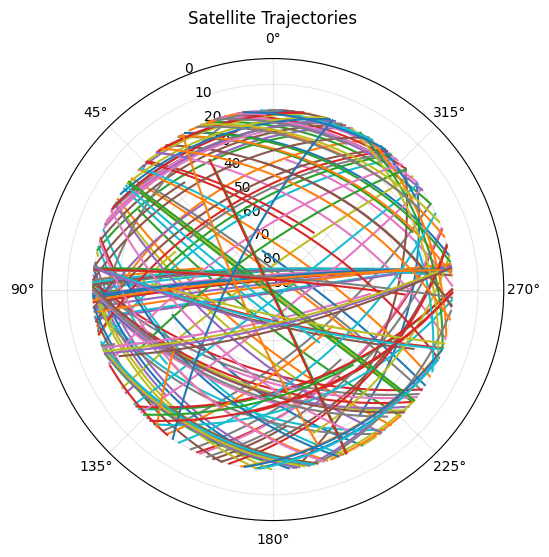

✓ Satellite trajectories saved as '02_satellite_trajectories.png'


In [19]:
print("Plotting satellite trajectories...")

# Plot satellite trajectories over the observation period
fig, ax = plot_satellite_trajectories(constellation, "Satellite Trajectories")
plt.savefig('02_satellite_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Satellite trajectories saved as '02_satellite_trajectories.png'")


## Step 7: Create Sky Model

Now let's create the sky temperature model that includes all the components we want to observe.


In [20]:
print("Creating sky temperature model...")

sky_model = create_sky_model(observation)
print("✓ Sky model created with components:")
print("  - Astronomical source (Cas A)")
print("  - Atmospheric emission")
print("  - Cosmic Microwave Background (2.73 K)")
print("  - Galactic background")
print("  - Radio Frequency Interference")


Creating sky temperature model...
✓ Sky model created with components:
  - Astronomical source (Cas A)
  - Atmospheric emission
  - Cosmic Microwave Background (2.73 K)
  - Galactic background
  - Radio Frequency Interference


## Step 8: Run Observations with Different Scenarios

Now let's run the observation simulations for different scenarios to compare the effects of satellite interference.


In [21]:
print("Running observation simulations...")

# Create separate observations for each scenario
obs_no_satellites = Observation.from_dates(
    OBSERVATION_START, OBSERVATION_END, pointing_trajectory, telescope, filt_funcs=(elevation_filter,)
)
obs_with_satellites = Observation.from_dates(
    OBSERVATION_START, OBSERVATION_END, pointing_trajectory, telescope, filt_funcs=(elevation_filter,)
)
obs_beam_avoid = Observation.from_dates(
    OBSERVATION_START, OBSERVATION_END, pointing_trajectory, telescope, filt_funcs=(elevation_filter,)
)

# Observation without satellites
print("  Running observation without satellite interference...")
start_time = time.time()
result_no_satellites = model_observed_temp(obs_no_satellites, sky_model)
end_time = time.time()
print(f"  ✓ Completed in {end_time - start_time:.2f} seconds")

# Observation with satellites (no beam avoidance)
print("  Running observation with satellite interference...")
start_time = time.time()
result_with_satellites = model_observed_temp(obs_with_satellites, sky_model, constellation)
end_time = time.time()
print(f"  ✓ Completed in {end_time - start_time:.2f} seconds")

# Observation with satellites and beam avoidance
print("  Running observation with satellite interference and beam avoidance...")
start_time = time.time()
result_with_beam_avoidance = model_observed_temp(
    obs_beam_avoid, sky_model, constellation_beam_avoid, beam_avoidance=True
)
end_time = time.time()
print(f"  ✓ Completed in {end_time - start_time:.2f} seconds")


Running observation simulations...
  Running observation without satellite interference...
  ✓ Completed in 0.01 seconds
  Running observation with satellite interference...
  ✓ Completed in 0.89 seconds
  Running observation with satellite interference and beam avoidance...
  ✓ Completed in 4.99 seconds


## Step 9: Analyze and Visualize Results

Now we can convert the temperature results to power and analyze the interference effects.


In [22]:
print("Analyzing and visualizing results...")

# Convert temperature to power
time_samples = obs_with_satellites.get_time_stamps()
power_no_satellites = temperature_to_power(result_no_satellites[:, 0, 0], BANDWIDTH)
power_with_satellites = temperature_to_power(result_with_satellites[:, 0, 0], BANDWIDTH)
power_with_beam_avoidance = temperature_to_power(result_with_beam_avoidance[:, 0, 0], BANDWIDTH)

print("✓ Results converted to power measurements")


Analyzing and visualizing results...
✓ Results converted to power measurements


## Step 10: Quantify Interference Impact

Now we'll calculate statistics to understand the impact of satellite interference on our observations.


In [23]:
print("Quantifying interference impact...")

# Calculate statistics for each scenario
off_source_mask = time_samples <= TIME_ON_SOURCE
on_source_mask = time_samples > TIME_ON_SOURCE

# OFF source statistics
off_power_no_sat = power_no_satellites[off_source_mask]
off_power_with_sat = power_with_satellites[off_source_mask]
off_power_with_avoid = power_with_beam_avoidance[off_source_mask]

# ON source statistics
on_power_no_sat = power_no_satellites[on_source_mask]
on_power_with_sat = power_with_satellites[on_source_mask]
on_power_with_avoid = power_with_beam_avoidance[on_source_mask]

print("OFF source statistics:")
print(f"  - No satellites: {np.mean(off_power_no_sat):.2e} W (std: {np.std(off_power_no_sat):.2e} W)")
print(f"  - With satellites: {np.mean(off_power_with_sat):.2e} W (std: {np.std(off_power_with_sat):.2e} W)")
print(f"  - With beam avoidance: {np.mean(off_power_with_avoid):.2e} W (std: {np.std(off_power_with_avoid):.2e} W)")

print("ON source statistics:")
print(f"  - No satellites: {np.mean(on_power_no_sat):.2e} W (std: {np.std(on_power_no_sat):.2e} W)")
print(f"  - With satellites: {np.mean(on_power_with_sat):.2e} W (std: {np.std(on_power_with_sat):.2e} W)")
print(f"  - With beam avoidance: {np.mean(on_power_with_avoid):.2e} W (std: {np.std(on_power_with_avoid):.2e} W)")

# Calculate interference metrics
interference_power = np.mean(off_power_with_sat) - np.mean(off_power_no_sat)
interference_reduction = (np.mean(off_power_with_sat) - np.mean(off_power_with_avoid)) / interference_power * 100

print("Interference Analysis:")
print(f"  - Interference power: {interference_power:.2e} W")
print(f"  - Beam avoidance effectiveness: {interference_reduction:.1f}% reduction")

# Calculate signal-to-noise ratios
snr_no_sat = (np.mean(on_power_no_sat) - np.mean(off_power_no_sat)) / np.std(off_power_no_sat)
snr_with_sat = (np.mean(on_power_with_sat) - np.mean(off_power_with_sat)) / np.std(off_power_with_sat)
snr_with_avoid = (np.mean(on_power_with_avoid) - np.mean(off_power_with_avoid)) / np.std(off_power_with_avoid)

print("Signal-to-Noise Ratios:")
print(f"  - No satellites: {snr_no_sat:.2f}")
print(f"  - With satellites: {snr_with_sat:.2f}")
print(f"  - With beam avoidance: {snr_with_avoid:.2f}")


Quantifying interference impact...
OFF source statistics:
  - No satellites: 1.13e-14 W (std: 3.21e-17 W)
  - With satellites: 2.32e-14 W (std: 5.86e-14 W)
  - With beam avoidance: 1.95e-14 W (std: 4.79e-14 W)
ON source statistics:
  - No satellites: 1.51e-14 W (std: 3.11e-17 W)
  - With satellites: 2.01e-14 W (std: 9.58e-15 W)
  - With beam avoidance: 1.79e-14 W (std: 4.85e-15 W)
Interference Analysis:
  - Interference power: 1.19e-14 W
  - Beam avoidance effectiveness: 31.5% reduction
Signal-to-Noise Ratios:
  - No satellites: 116.55
  - With satellites: -0.05
  - With beam avoidance: -0.03


## Step 11: Compare Different Satellite Models

Now we can compare the ITU gain pattern with a constant gain pattern to see how different antenna models affect interference.


In [24]:
print("Comparing different satellite models...")

# Create constellation with constant gain satellite
constellation_constant = Constellation.from_file(
    STARLINK_TRAJECTORY_FILE,
    observation,
    constant_gain_satellite,
    lnk_bdgt,
    name_tag='sat',
    time_tag='timestamp',
    elevation_tag='elevations',
    azimuth_tag='azimuths',
    distance_tag='ranges_westford',
    filt_funcs=(('sat', lambda s: ~s.str.contains('DTC')), ('elevations', lambda e: e > 20.0))
)

# Create separate observation for constant gain scenario
obs_constant_gain = Observation.from_dates(
    OBSERVATION_START, OBSERVATION_END, pointing_trajectory, telescope, filt_funcs=(elevation_filter,)
)

# Run observation with constant gain satellites
print("  Running observation with constant gain satellites...")
start_time = time.time()
result_constant_gain = model_observed_temp(obs_constant_gain, sky_model, constellation_constant)
end_time = time.time()
print(f"  ✓ Completed in {end_time - start_time:.2f} seconds")

# Convert to power
power_constant_gain = temperature_to_power(result_constant_gain[:, 0, 0], BANDWIDTH)

# Compare interference levels
interference_itu = np.mean(off_power_with_sat) - np.mean(off_power_no_sat)
interference_constant = np.mean(power_constant_gain[off_source_mask]) - np.mean(off_power_no_sat)

print("Satellite Model Comparison:")
print(f"  - ITU gain pattern interference: {interference_itu:.2e} W")
print(f"  - Constant gain pattern interference: {interference_constant:.2e} W")
print(f"  - Difference: {abs(interference_itu - interference_constant):.2e} W")


Comparing different satellite models...
  Running observation with constant gain satellites...
  ✓ Completed in 0.89 seconds
Satellite Model Comparison:
  - ITU gain pattern interference: 1.19e-14 W
  - Constant gain pattern interference: 5.27e-15 W
  - Difference: 6.62e-15 W


## Step 12: Four-Scenario Comparison Plot

Finally, let's create a comprehensive comparison plot for all four scenarios.


Creating four-scenario comparison plot...


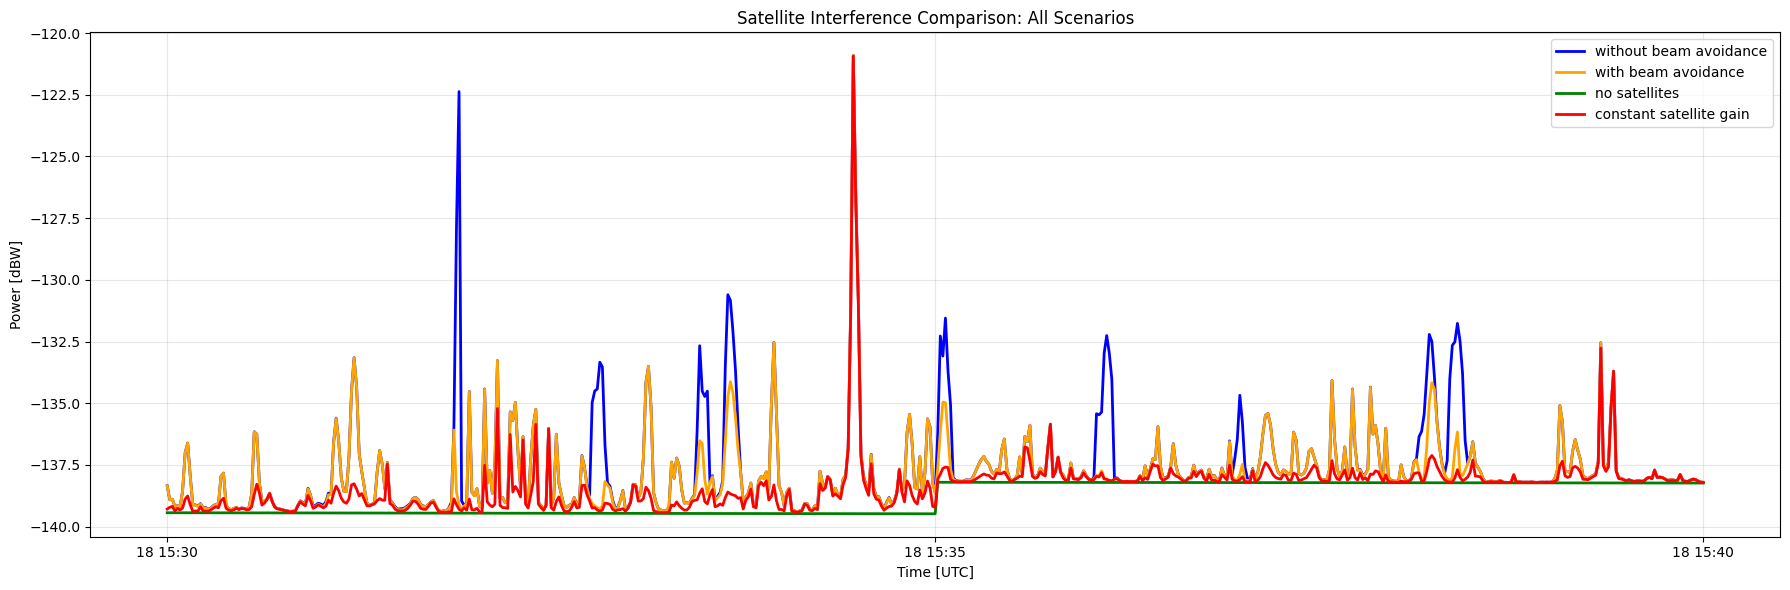

✓ Four-scenario comparison saved as '02_satellite_interference_comparison_all_scenarios.png'


In [25]:
print("Creating four-scenario comparison plot...")

# Create comparison plot with all four scenarios
fig, ax = plt.subplots(figsize=(18, 6))

# Plot all four scenarios
# Without beam avoidance (blue)
ax.plot(time_samples, 10 * np.log10(power_with_satellites),
        label="without beam avoidance", linewidth=2, color='blue')

# With beam avoidance (orange)
ax.plot(time_samples, 10 * np.log10(power_with_beam_avoidance),
        label="with beam avoidance", linewidth=2, color='orange')

# No satellites (green)
ax.plot(time_samples, 10 * np.log10(power_no_satellites),
        label="no satellites", linewidth=2, color='green')

# Constant satellite gain (red)
ax.plot(time_samples, 10 * np.log10(power_constant_gain),
        label="constant satellite gain", linewidth=2, color='red')

ax.legend()
ax.set_xlabel("Time [UTC]")
ax.set_ylabel("Power [dBW]")
ax.set_title("Satellite Interference Comparison: All Scenarios")
ax.grid(True)
fig.tight_layout()

plt.savefig('02_satellite_interference_comparison_all_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Four-scenario comparison saved as '02_satellite_interference_comparison_all_scenarios.png'")


## Summary

Congratulations! You have successfully completed Tutorial 02. 
